# Conditional Generative Advarsarial Network 

Here is presented the following parper https://arxiv.org/abs/1411.1784

This work is similar to the previous one but now the G(z) is replaced with G(z|y) and D(x) by D(x|y). 
Since we only need to modify the Generator and Discriminator network the previous code dont change to much (loss, otimization)

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


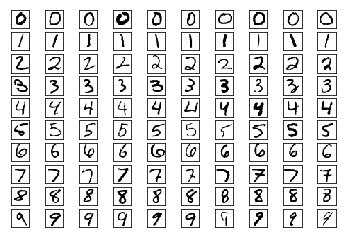

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")

#ut.plot_mnist_images(mnist.test.images[0:9])

#reset graph using during notebook development
#tf.reset_default_graph()
images_per_class = 10
images = np.zeros((10*images_per_class,mnist_flat_size))
for l in range(10):
    images[(l*images_per_class):(l*images_per_class+images_per_class)] = mnist.test.images[(mnist.test.labels==l)][:images_per_class]
    
ut.plot_mnist_images_conditonal(images,per_class = images_per_class)


### Generator network 

Same as previous network, only diference is that input Z is concatenated with y

In [3]:
#array that contain the network dimention at least 3 dimention (input, hidden and output dimentions)
z_dimention = 100

G_dimentions = [z_dimention,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='number_label')

def generator(x,y):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param y: tensor with shape (M,10) labels in one hot encoder
    :return: tensor with shape (M,784) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):

        he_init = tf.contrib.layers.variance_scaling_initializer()
        
        concat_input = tf.concat([x, y], 1)
        
        g_net = tf.layers.dense(concat_input,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        return g_net


### Discriminator network 

Same as previous network, only diference is that input Z is concatenated with y

In [4]:
#array that contain the network dimention at least 3 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput fake, true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x,y):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :param y: tensor with shape (10,1) labels in one hot encoder
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        he_init = tf.contrib.layers.variance_scaling_initializer()
        concat_input = tf.concat([x, y], 1)
        
        d_net = tf.layers.dense(concat_input,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE,kernel_initializer=he_init)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Loss functions Generator and Discriminator

Same as previous one

In [5]:

#this alternative loss use cross entropy (explanation why this makes senses TODO)
alternative_loss = True

with tf.name_scope("generator_loss"): 
    generated_sample = generator(Z,Y)
    d_fake_prob, d_fake_logits = discriminator(generated_sample,Y) #D(G(Z|Y)|Y)
    
    if alternative_loss:
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob, d_true_logits = discriminator(X,Y)
    if alternative_loss:
        d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits, labels=tf.ones_like(d_true_logits)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
        d_loss = d_loss_fake + d_loss_true
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))

#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [6]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'g_hidden1/kernel:0' shape=(110, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(794, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


### Training Algorithm

Epoach 0
Discriminator loss:  2.0613
Generator loss: 1.56672


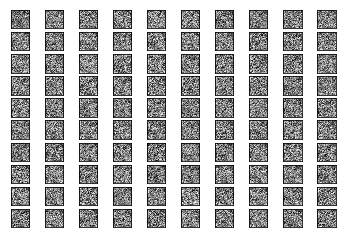

Epoach 100
Discriminator loss:  0.200196
Generator loss: 4.15592


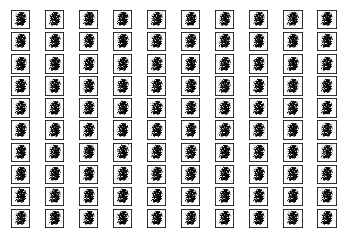

Epoach 200
Discriminator loss:  0.0934005
Generator loss: 4.76033


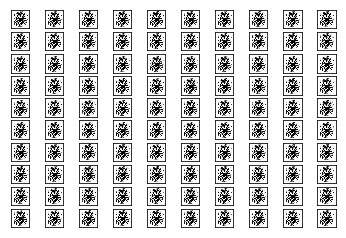

Epoach 300
Discriminator loss:  0.0385841
Generator loss: 5.22117


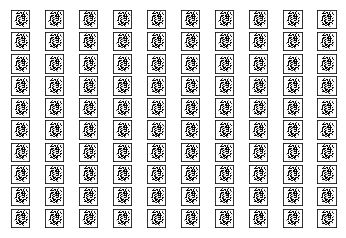

Epoach 400
Discriminator loss:  0.026343
Generator loss: 5.40071


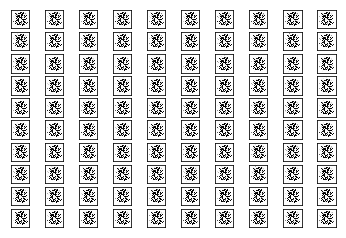

Epoach 500
Discriminator loss:  0.0155404
Generator loss: 6.38914


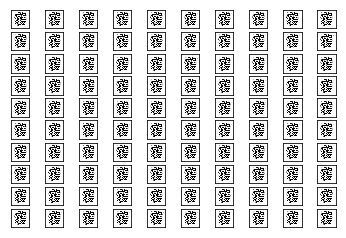

Epoach 600
Discriminator loss:  0.00799504
Generator loss: 6.80665


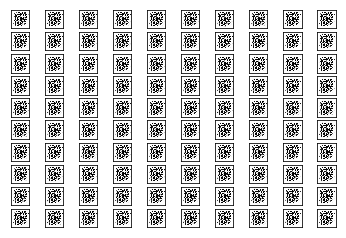

Epoach 700
Discriminator loss:  0.00593808
Generator loss: 6.91541


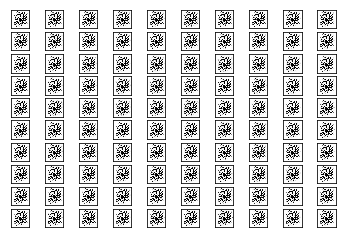

Epoach 800
Discriminator loss:  0.00586676
Generator loss: 8.60412


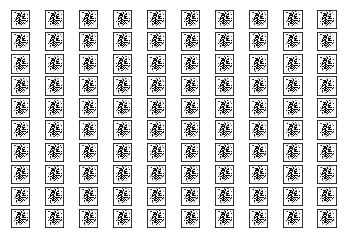

Epoach 900
Discriminator loss:  0.00815914
Generator loss: 7.9462


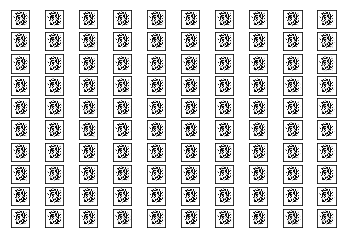

Epoach 1000
Discriminator loss:  0.00571562
Generator loss: 6.81113


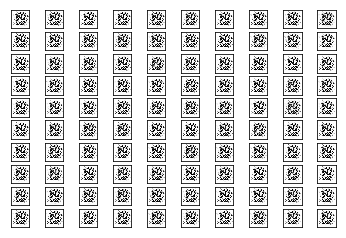

Epoach 1100
Discriminator loss:  0.00350298
Generator loss: 7.62873


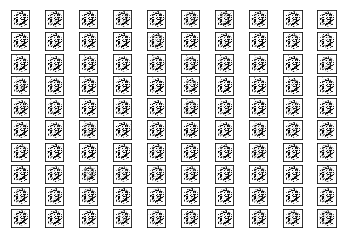

Epoach 1200
Discriminator loss:  0.0149532
Generator loss: 5.78608


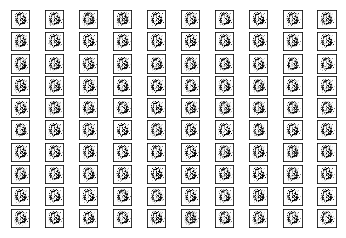

Epoach 1300
Discriminator loss:  0.0227783
Generator loss: 4.97877


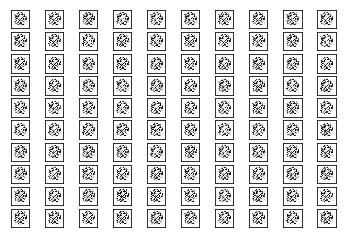

Epoach 1400
Discriminator loss:  0.0178983
Generator loss: 6.26867


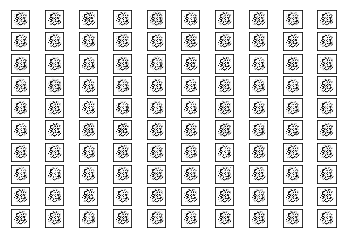

Epoach 1500
Discriminator loss:  0.0203635
Generator loss: 5.4575


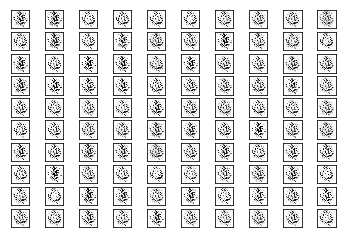

Epoach 1600
Discriminator loss:  0.013654
Generator loss: 5.69636


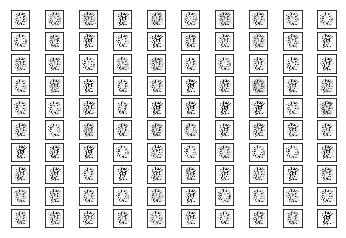

Epoach 1700
Discriminator loss:  0.105291
Generator loss: 4.23792


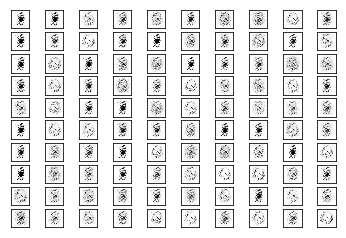

Epoach 1800
Discriminator loss:  0.0762984
Generator loss: 4.9035


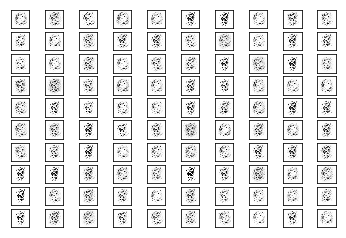

Epoach 1900
Discriminator loss:  0.0450155
Generator loss: 5.52916


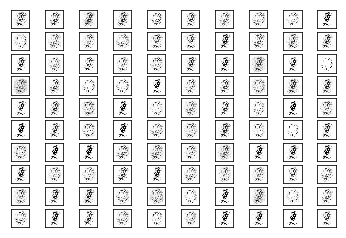

Epoach 2000
Discriminator loss:  0.0198119
Generator loss: 5.8398


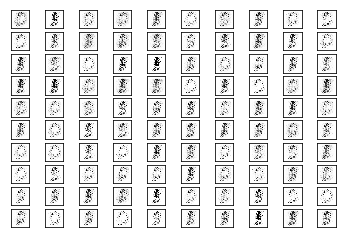

Epoach 2100
Discriminator loss:  0.0487563
Generator loss: 4.59132


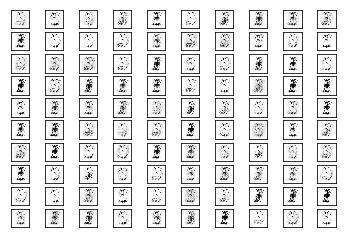

Epoach 2200
Discriminator loss:  0.167336
Generator loss: 4.68805


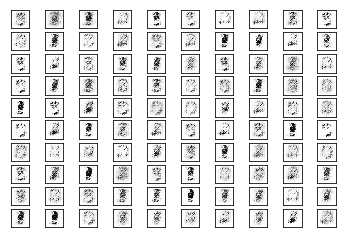

Epoach 2300
Discriminator loss:  0.0899316
Generator loss: 4.6069


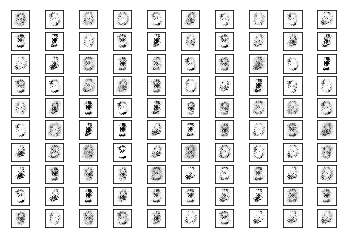

Epoach 2400
Discriminator loss:  0.174729
Generator loss: 4.06167


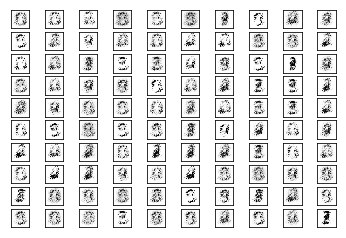

Epoach 2500
Discriminator loss:  0.158901
Generator loss: 4.03327


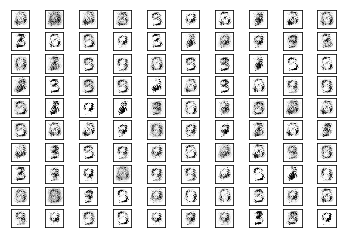

Epoach 2600
Discriminator loss:  0.312878
Generator loss: 4.50722


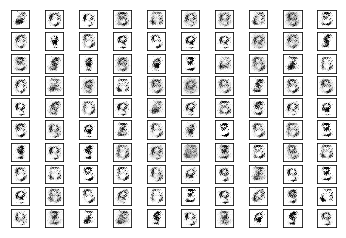

Epoach 2700
Discriminator loss:  0.090483
Generator loss: 5.36278


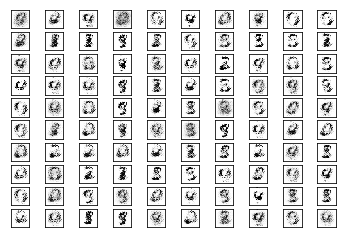

Epoach 2800
Discriminator loss:  0.0449178
Generator loss: 4.54825


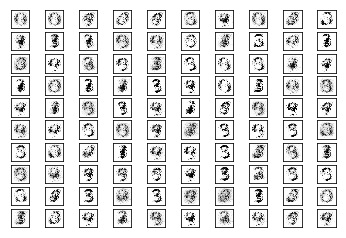

Epoach 2900
Discriminator loss:  0.0812189
Generator loss: 5.48041


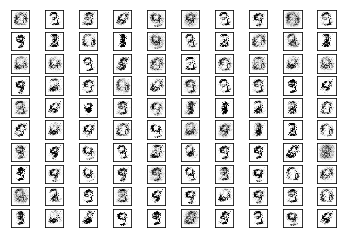

Epoach 3000
Discriminator loss:  0.0435388
Generator loss: 6.40653


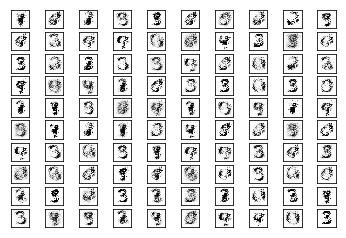

Epoach 3100
Discriminator loss:  0.0790088
Generator loss: 7.07728


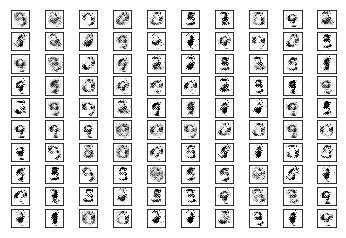

Epoach 3200
Discriminator loss:  0.138254
Generator loss: 5.56023


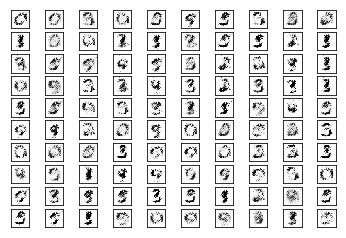

Epoach 3300
Discriminator loss:  0.138538
Generator loss: 6.79508


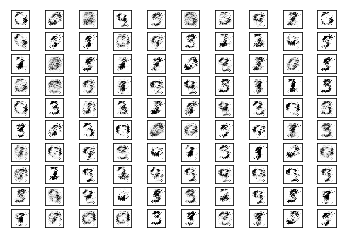

Epoach 3400
Discriminator loss:  0.0834448
Generator loss: 5.82455


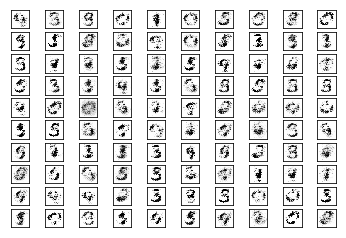

Epoach 3500
Discriminator loss:  0.117498
Generator loss: 4.64496


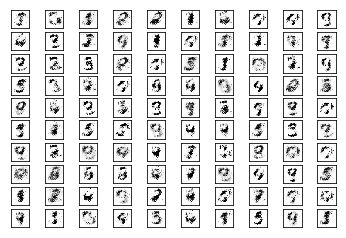

Epoach 3600
Discriminator loss:  0.173081
Generator loss: 5.1357


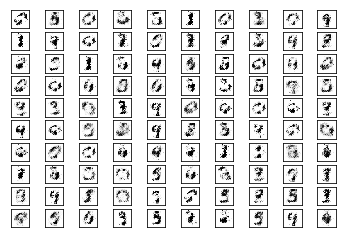

Epoach 3700
Discriminator loss:  0.190176
Generator loss: 5.60946


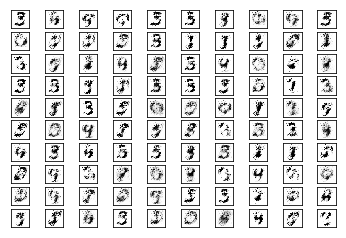

Epoach 3800
Discriminator loss:  0.127556
Generator loss: 5.24437


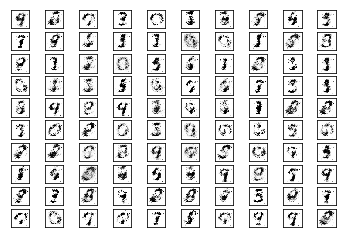

Epoach 3900
Discriminator loss:  0.18174
Generator loss: 7.27128


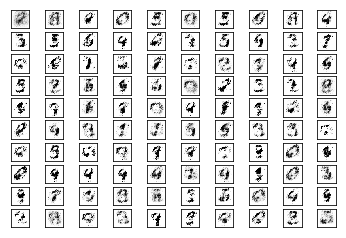

Epoach 4000
Discriminator loss:  0.0910864
Generator loss: 5.6457


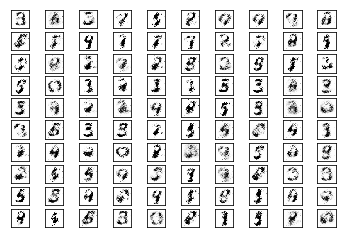

Epoach 4100
Discriminator loss:  0.141327
Generator loss: 5.0901


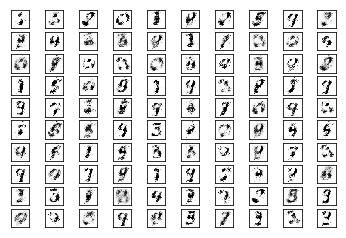

Epoach 4200
Discriminator loss:  0.0664548
Generator loss: 5.56757


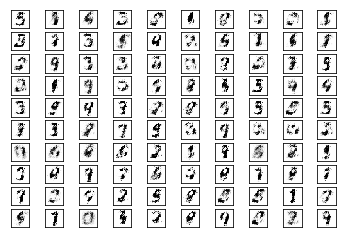

Epoach 4300
Discriminator loss:  0.228411
Generator loss: 5.49144


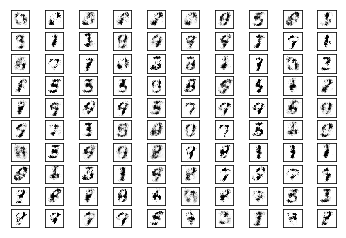

Epoach 4400
Discriminator loss:  0.272442
Generator loss: 3.95174


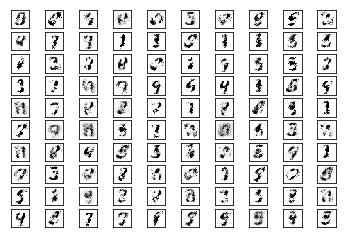

Epoach 4500
Discriminator loss:  0.164389
Generator loss: 5.68764


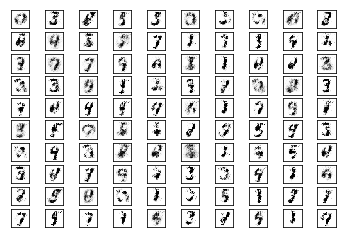

Epoach 4600
Discriminator loss:  0.269742
Generator loss: 4.84752


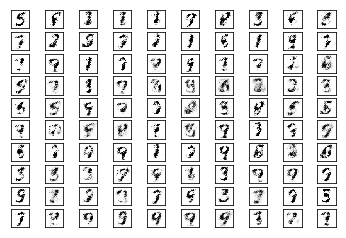

Epoach 4700
Discriminator loss:  0.180854
Generator loss: 4.92521


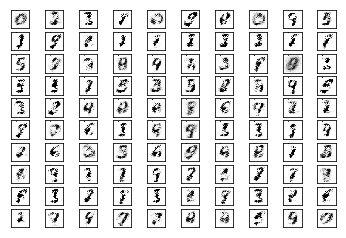

Epoach 4800
Discriminator loss:  0.317783
Generator loss: 4.64588


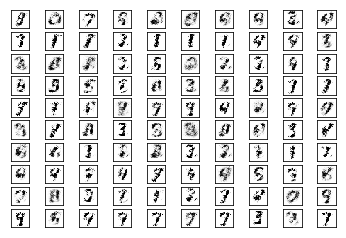

Epoach 4900
Discriminator loss:  0.323371
Generator loss: 4.23108


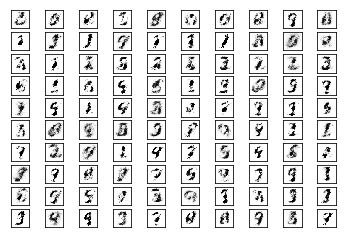

Epoach 5000
Discriminator loss:  0.243185
Generator loss: 4.97074


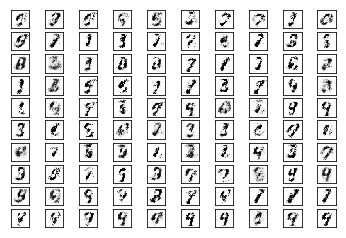

Epoach 5100
Discriminator loss:  0.330241
Generator loss: 5.10381


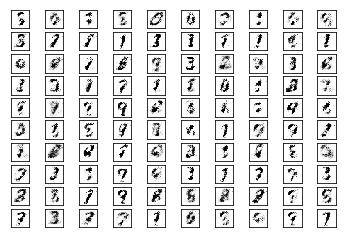

Epoach 5200
Discriminator loss:  0.262055
Generator loss: 4.59531


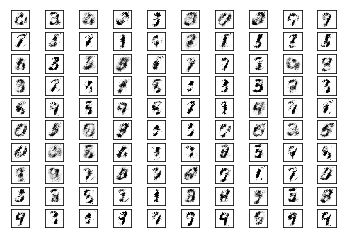

Epoach 5300
Discriminator loss:  0.35035
Generator loss: 4.36981


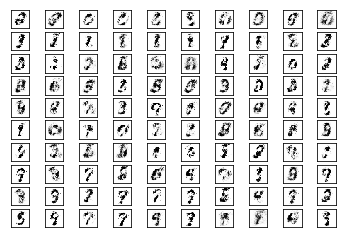

Epoach 5400
Discriminator loss:  0.223836
Generator loss: 5.22388


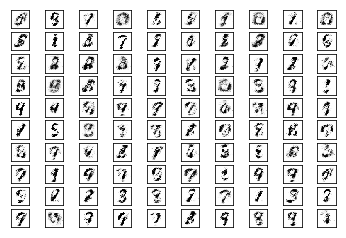

Epoach 5500
Discriminator loss:  0.259076
Generator loss: 4.26159


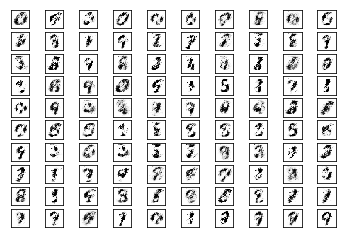

Epoach 5600
Discriminator loss:  0.481045
Generator loss: 3.29012


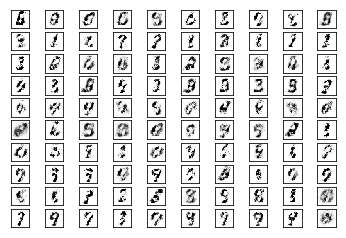

Epoach 5700
Discriminator loss:  0.367089
Generator loss: 4.26217


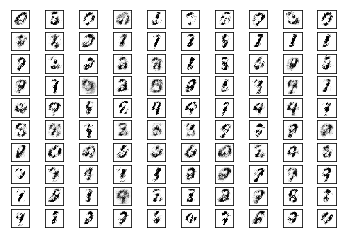

Epoach 5800
Discriminator loss:  0.346979
Generator loss: 4.95779


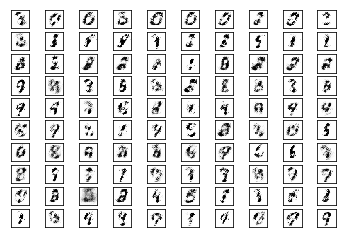

Epoach 5900
Discriminator loss:  0.330415
Generator loss: 4.47473


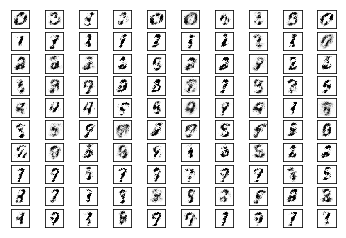

Epoach 6000
Discriminator loss:  0.317975
Generator loss: 3.92729


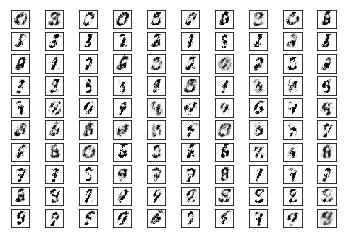

Epoach 6100
Discriminator loss:  0.360299
Generator loss: 4.90383


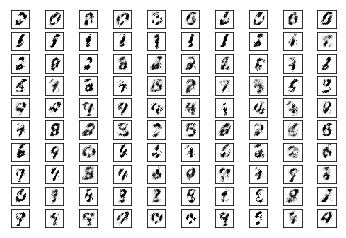

Epoach 6200
Discriminator loss:  0.283759
Generator loss: 5.37353


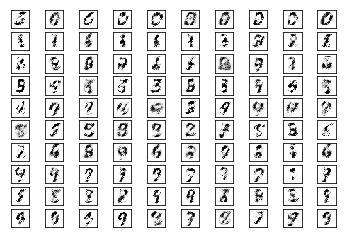

Epoach 6300
Discriminator loss:  0.219861
Generator loss: 4.68728


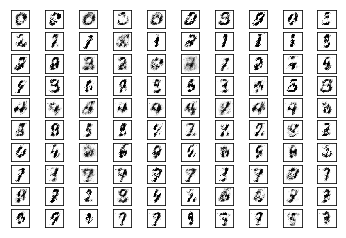

Epoach 6400
Discriminator loss:  0.271072
Generator loss: 5.11226


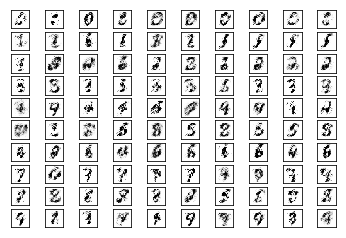

Epoach 6500
Discriminator loss:  0.457289
Generator loss: 4.22049


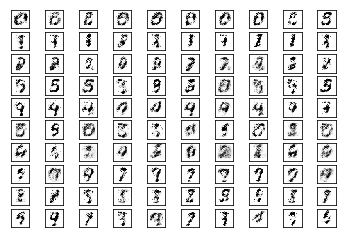

Epoach 6600
Discriminator loss:  0.264627
Generator loss: 4.58067


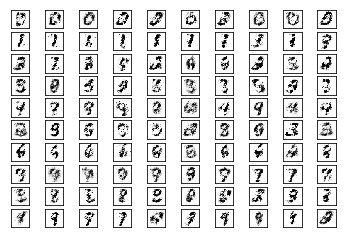

Epoach 6700
Discriminator loss:  0.327248
Generator loss: 4.65335


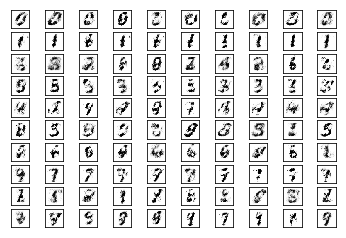

Epoach 6800
Discriminator loss:  0.416942
Generator loss: 4.31127


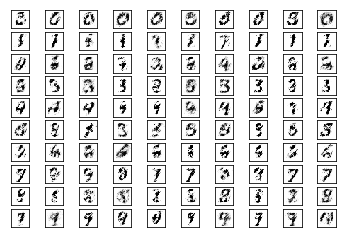

Epoach 6900
Discriminator loss:  0.472626
Generator loss: 2.77687


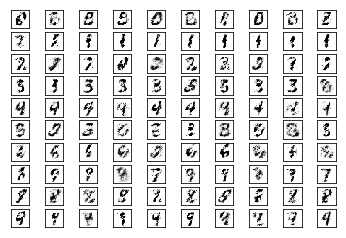

Epoach 7000
Discriminator loss:  0.424339
Generator loss: 4.0874


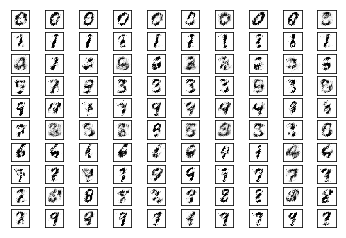

Epoach 7100
Discriminator loss:  0.452835
Generator loss: 4.16837


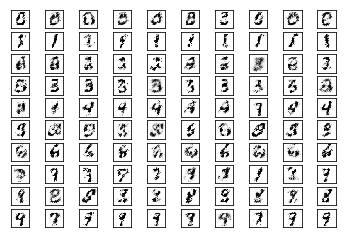

Epoach 7200
Discriminator loss:  0.476094
Generator loss: 3.13536


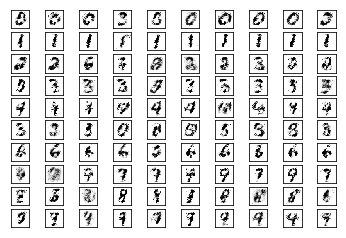

Epoach 7300
Discriminator loss:  0.36476
Generator loss: 3.90639


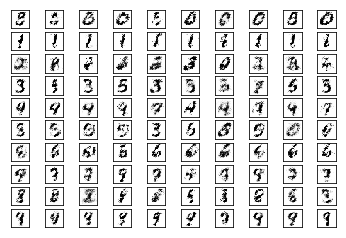

Epoach 7400
Discriminator loss:  0.592377
Generator loss: 3.96152


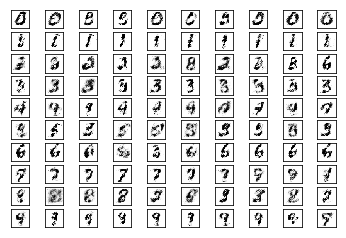

Epoach 7500
Discriminator loss:  0.626744
Generator loss: 4.47796


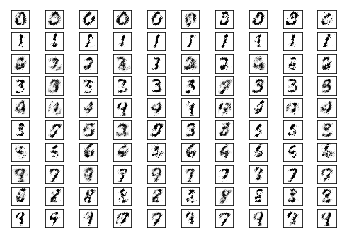

Epoach 7600
Discriminator loss:  0.475946
Generator loss: 3.26296


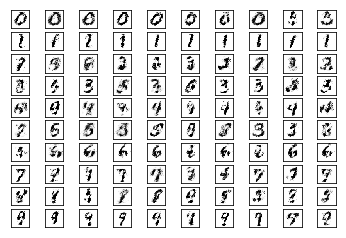

Epoach 7700
Discriminator loss:  0.347991
Generator loss: 4.05997


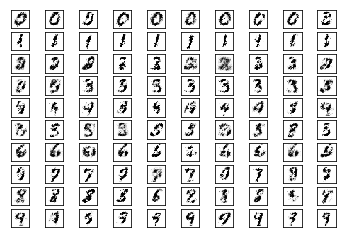

Epoach 7800
Discriminator loss:  0.975863
Generator loss: 2.87802


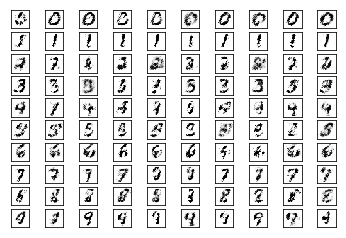

Epoach 7900
Discriminator loss:  0.591331
Generator loss: 2.58511


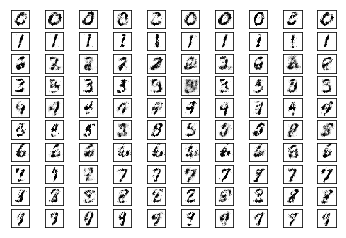

Epoach 8000
Discriminator loss:  0.39183
Generator loss: 4.28848


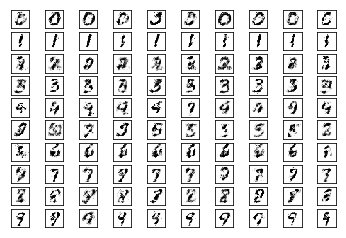

Epoach 8100
Discriminator loss:  0.682356
Generator loss: 2.60298


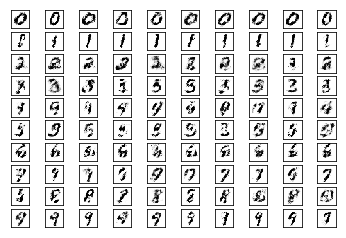

Epoach 8200
Discriminator loss:  0.532888
Generator loss: 3.84777


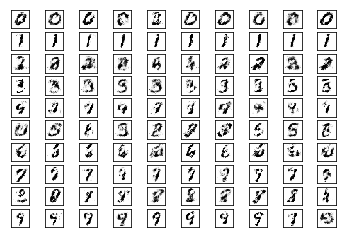

Epoach 8300
Discriminator loss:  0.375963
Generator loss: 3.19655


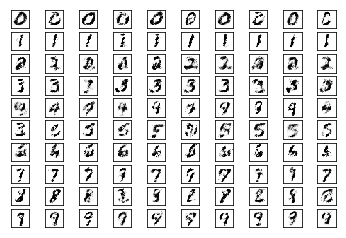

Epoach 8400
Discriminator loss:  0.404414
Generator loss: 3.61647


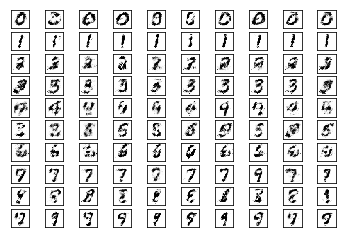

Epoach 8500
Discriminator loss:  0.484354
Generator loss: 3.3437


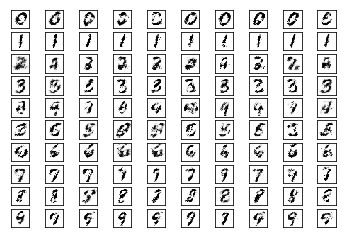

Epoach 8600
Discriminator loss:  0.5097
Generator loss: 2.6448


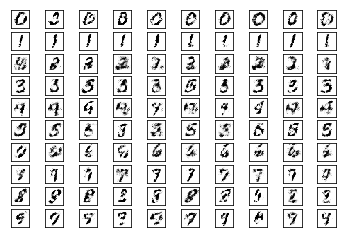

Epoach 8700
Discriminator loss:  0.352376
Generator loss: 3.43196


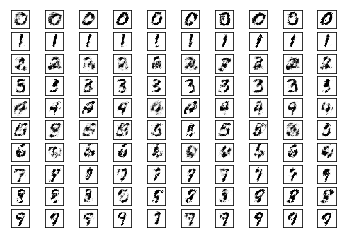

Epoach 8800
Discriminator loss:  0.561593
Generator loss: 3.25283


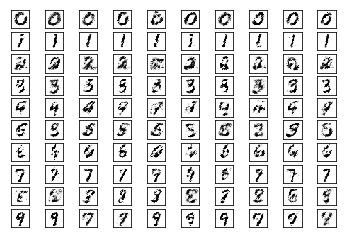

Epoach 8900
Discriminator loss:  0.662922
Generator loss: 3.08648


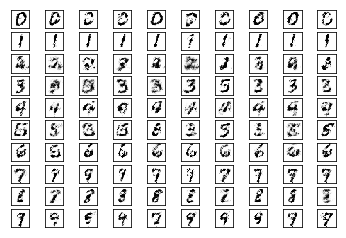

Epoach 9000
Discriminator loss:  0.73706
Generator loss: 2.79245


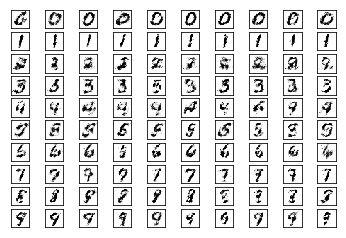

Epoach 9100
Discriminator loss:  0.439379
Generator loss: 3.17301


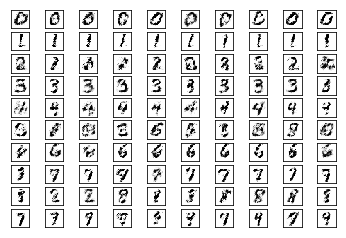

Epoach 9200
Discriminator loss:  0.703138
Generator loss: 2.44545


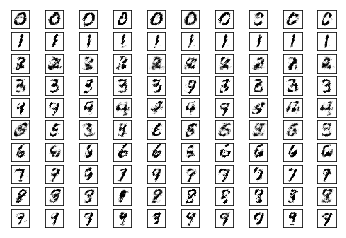

Epoach 9300
Discriminator loss:  0.745661
Generator loss: 3.09351


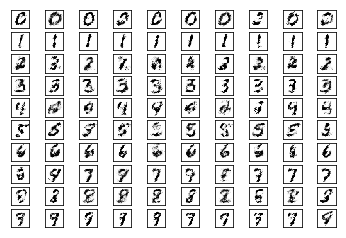

Epoach 9400
Discriminator loss:  0.824369
Generator loss: 3.02997


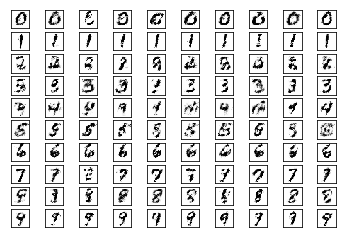

Epoach 9500
Discriminator loss:  0.741203
Generator loss: 2.65484


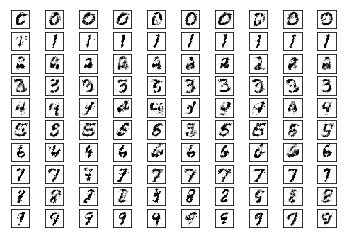

Epoach 9600
Discriminator loss:  0.500555
Generator loss: 2.70041


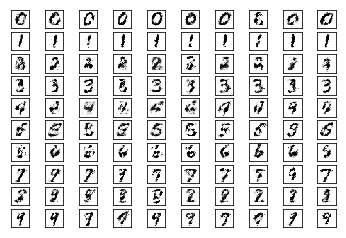

Epoach 9700
Discriminator loss:  0.483216
Generator loss: 2.85074


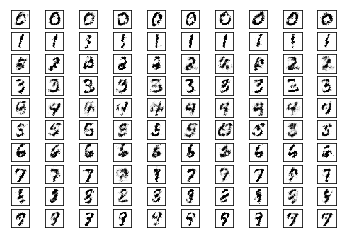

Epoach 9800
Discriminator loss:  0.619433
Generator loss: 2.82747


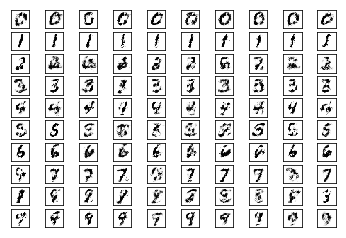

Epoach 9900
Discriminator loss:  0.743756
Generator loss: 1.9938


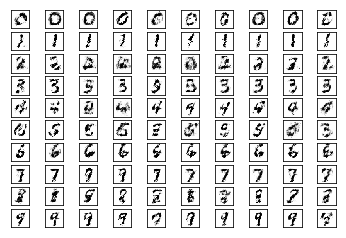

In [7]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


def random_Z(m, n=z_dimention):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

def random_y(m):
    '''
    Random labels y in one hot encoding
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return one_hot(np.random.randint(10,size=[m,1]))


def one_hot(label):
    '''
    Apply one hot encoding to the label
    
    :param label: Vector with shape (Mx1)
    :return: Matrix with shape (Mx10)
    '''
    #print(len(label))
    m = np.zeros((len(label),10))
    m[np.arange(len(label)), label] = 1
    return m
    
## Start graph computations and algorithm


batch_size = 128
epoach = 100000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    y_one_hot = one_hot(y_train)
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train,Y:y_one_hot , Z: random_Z(batch_size)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: random_Z(batch_size),Y:y_one_hot})

    if i%1000 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = random_Z(images_per_class*10)
                
        conditional_y = one_hot(np.repeat(list(range(10)), images_per_class))
        
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new,Y:conditional_y})
        ut.plot_mnist_images_conditonal(generated_images,per_class = images_per_class)
